In [1]:
import mdtraj as md
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
import pandas as pd

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})


In [3]:
# block function from pyblock package -  https://github.com/jsspencer/pyblock
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances
    # for each blocking transformation
    for i in arange(0, d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum((x[0:(n-1)]-mu)*(x[1:n]-mu))
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]

    # we need a list of magic numbers
    q = array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0, d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))


def free_energy_1D_blockerror(a, T, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(histo)
    # free_energy=-(0.001987*T)*np.log(histo)
    free_energy = -(0.001987*T)*np.log(histo+.000001)
    free_energy = free_energy-np.min(free_energy)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    ferr = -(0.001987*T)*(error / average)
    return free_energy, xcenters, ferr


def chunkIt(a, num):
    avg = a / float(num)
    out = []
    last = 0.0
    while last < a-1:
        out.append([int(last), int(last+avg)])
        last += avg
    return out


def histo_blockerror(a, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    return average, xcenters, error


def Kd_calc(bound, conc):
    return((1-bound)*conc/bound)


def get_blockerrors(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        be = block(data)**.5
        ave.append(np.average(data))
        block_errors.append(be)
    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac

    return ave_bf, be_bf


def get_blockerrors_pyblock(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        if (average != 0) and (average != 1):
            reblock_data = pyblock.blocking.reblock(data)
            opt = pyblock.blocking.find_optimal_block(
                len(data), reblock_data)[0]
            opt_block = reblock_data[opt]
            be = opt_block[4]
        else:
            be = 0
        ave.append(average)
        block_errors.append(be)

    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac
    return ave_bf, be_bf


def get_blockerror(Data):
    data = Data
    average = np.average(data)
    be = block(data)**.5
    return average, be


def get_blockerror_pyblock(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)


def get_blockerror_pyblock_nanskip(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        if(math.isnan(opt)):
            be_max = 0
            for i in range(0, len(reblock_data)):
                be = reblock_data[i][4]
                if(be > be_max):
                    be_max = be
        else:
            be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)

In [7]:
!pwd

/data/asn/tica/lig_47/dist


In [8]:
outdir = '/data/asn/'
pdb = '/data/asn/biorxiv2021-6626290-no-water-glue/lig47.pdb'
rep0 = '/data/asn/biorxiv2021-6626290-no-water-glue/ligand_47_1.xtc'
#helixpdb = './Trajectory_Files_12.20.21/R2R3_all_helix.pdb'
#apodir = './Trajectory_Files_12.20.21/R2_R3_APO/'

# table,bonds = md.load(pdb).topology.to_dataframe()
# first = table[table["resSeq"]==121].to_numpy()
# first[:,0] = np.arange(1, 1+len(first))
# second = table[table["resSeq"]!=121].to_numpy()
# second[:,0] = np.arange(first[-1,0]+1, first[-1,0]+1 + len(second))
# final = np.concatenate([first, second], axis=0)
# df = pd.DataFrame(data = final, columns = table.columns)
# top_fix = md.Topology.from_dataframe(df, bonds)
#trj = md.load(rep0, top =top_fix)
trj = md.load(rep0, top =pdb)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames = trj.n_frames

In [9]:
nres = []
for res in trj.topology.residues:
    nres.append(res.resSeq)
sequence = (' %s' % [residue for residue in trj.topology.residues])
resname = (' %s' % [residue.name for residue in trj.topology.residues])
resindex = (' %s' % [residue.index for residue in trj.topology.residues])
prot_top = top.subset(top.select('protein'))
prot_res = []
for res in prot_top.residues:
    prot_res.append(res.resSeq)
prot_resname = (' %s' % [residue.name for residue in prot_top.residues])
residues = len(set(prot_res))

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)


residue_offset = 0
prot_res_renum = np.asarray(prot_res)+residue_offset
residue_number = range(0, residues)
residue_number_offsetres = range(residue_offset, residue_offset+residues)



** SYSTEM INFO **

Number of atoms: 338

Number of residues: 21

Number of protein residues: 20

Number of frames: 1100889

Starting frame: 0

Last frame: 1100889

sequence:  [ASP121, ASN122, GLU123, ALA124, TYR125, GLU126, MET127, PRO128, SER129, GLU130, GLU131, GLY132, TYR133, GLN134, ASP135, TYR136, GLU137, PRO138, GLU139, ALA140, ASP121, <1>1]

residue names:  ['ASP', 'ASN', 'GLU', 'ALA', 'TYR', 'GLU', 'MET', 'PRO', 'SER', 'GLU', 'GLU', 'GLY', 'TYR', 'GLN', 'ASP', 'TYR', 'GLU', 'PRO', 'GLU', 'ALA', 'ASP', '<1>']

residue index:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]



In [10]:
for i in range(trj.n_residues):print([trj.topology.atom(i) for i in trj.topology.select(f"resid {i}")], "\n")

[ASP121-N, ASP121-CA, ASP121-C, ASP121-O, ASP121-CB, ASP121-CG, ASP121-OD1, ASP121-OD2, ASP121-H, ASP121-HA, ASP121-HB2, ASP121-HB3] 

[ASN122-N, ASN122-CA, ASN122-C, ASN122-O, ASN122-CB, ASN122-CG, ASN122-OD1, ASN122-ND2, ASN122-H, ASN122-HA, ASN122-HB2, ASN122-HB3, ASN122-HD21, ASN122-HD22] 

[GLU123-N, GLU123-CA, GLU123-C, GLU123-O, GLU123-CB, GLU123-CG, GLU123-CD, GLU123-OE1, GLU123-OE2, GLU123-H, GLU123-HA, GLU123-HB2, GLU123-HB3, GLU123-HG2, GLU123-HG3] 

[ALA124-N, ALA124-CA, ALA124-C, ALA124-O, ALA124-CB, ALA124-H, ALA124-HA, ALA124-HB1, ALA124-HB2, ALA124-HB3] 

[TYR125-N, TYR125-CA, TYR125-C, TYR125-O, TYR125-CB, TYR125-CG, TYR125-CD1, TYR125-CD2, TYR125-CE1, TYR125-CE2, TYR125-CZ, TYR125-OH, TYR125-H, TYR125-HA, TYR125-HB2, TYR125-HB3, TYR125-HD1, TYR125-HD2, TYR125-HE1, TYR125-HE2, TYR125-HH] 

[GLU126-N, GLU126-CA, GLU126-C, GLU126-O, GLU126-CB, GLU126-CG, GLU126-CD, GLU126-OE1, GLU126-OE2, GLU126-H, GLU126-HA, GLU126-HB2, GLU126-HB3, GLU126-HG2, GLU126-HG3] 

[MET127-N, M

In [6]:
 [trj.topology.residue(i) for i in range(trj.n_residues)]

[ASP121,
 ASN122,
 GLU123,
 ALA124,
 TYR125,
 GLU126,
 MET127,
 PRO128,
 SER129,
 GLU130,
 GLU131,
 GLY132,
 TYR133,
 GLN134,
 ASP135,
 TYR136,
 GLU137,
 PRO138,
 GLU139,
 ALA140,
 <1>1]

In [7]:
def distance_matrix(sel1,sel2,offset1,offset2,traj,measure,periodic):
    ''' RETURNS: dmat,np.array(pairs),np.array(pairs_index),index,columns,len(sel1)..(x),len(sel2)....(y)
    '''
    pair_distances = []
    pairs = []
    pairs_index = []
    if measure == "residues":
        index = [traj.topology.residue(i) for i in sel1]
        columns = [traj.topology.residue(j) for j in sel2]
        for i in sel1:
            for j in sel2:
                pairs.append("{},{}".format(traj.topology.residue(i),traj.topology.residue(j)))
                pairs_index.append([i+offset1,j+offset2])
                if i==j:
                    dist = np.zeros(traj.n_frames)
                    pair_distances.append(dist)
                else:
                    dist = md.compute_contacts(traj,[[i,j]],periodic=periodic)[0][:,0]
                    pair_distances.append(dist)
    if measure == "atoms":
        index = [traj.topology.atom(i) for i in sel1]
        columns = [traj.topology.atom(j) for j in sel2]
        for i in sel1:
            for j in sel2:
                pairs.append("{},{}".format(traj.topology.atom(i),traj.topology.atom(j)))
                pairs_index.append([i+offset1,j+offset2])
                if i==j:
                    dist = np.zeros(traj.n_frames)
                    pair_distances.append(dist)
                else:
                    dist = md.compute_distances(traj,[[i,j]],periodic=periodic)[:,0]
                    pair_distances.append(dist)
    dist_feat_arr = np.stack(pair_distances,axis=1)
    return dist_feat_arr,np.array(pairs),np.array(pairs_index),index,columns,np.array([len(sel1),len(sel2)])
dmat, pairs, pairs_idx, index, col, xy = distance_matrix(np.arange(0,20),[20], 0,0,trj,"residues", True)
dmat_bin = np.where(dmat<.5,1,0)

In [4]:
dmat = np.load("/data/asn/tica/lig_47/dist/distance_matrix_full_LIG.npy")

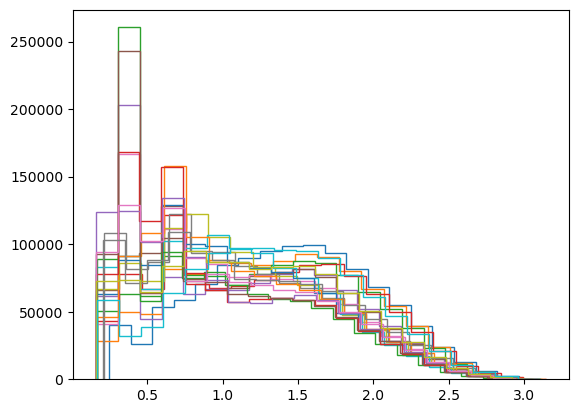

In [5]:
for i in range(0,20):
   plt.hist((dmat[:,i]),histtype='step',bins=20,label=i) 

In [9]:
#dmat_intra = distance_matrix(np.arange(1,21),np.arange(1,21), 0,0,trj,"residues", True)[0]

In [6]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import deeptime
from deeptime.decomposition import TICA
import pyemma
from deeptime.clustering import KMeans

In [7]:
def tica(data, lagtime, var_cutoff):
    '''RETURNS: projected data on tics, tica object
    '''
    est = TICA(lagtime=lagtime, var_cutoff = var_cutoff).fit(data)
    tica = est.fetch_model()
    plt.scatter(np.arange(20),tica.singular_values[:20])
    plt.xticks(np.arange(20),np.arange(20))
    plt.title("Eigen Values")
    return tica.transform(data), tica
def kmeans(p,k):
    '''RETURNS: dtraj, frames_cl, clustercenters
    '''
    cluster = KMeans(k,max_iter=1000).fit_fetch(p)
    dtraj = cluster.transform(p)
    frames_cl = []
    for i in range(k):
        frames = np.where(dtraj==i)[0]
        frames_cl.append(frames)
    return dtraj,frames_cl,cluster.cluster_centers
def res_space(nres,space):
    arr = np.arange(nres)
    l = []
    for i in range(nres):
        l.append(arr[abs(arr-i)>space]+i*nres)
    return np.hstack(l)

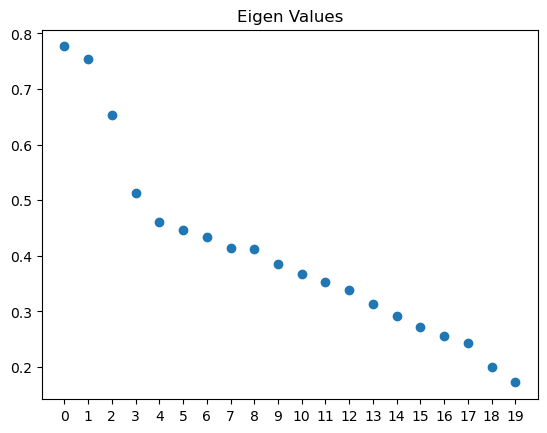

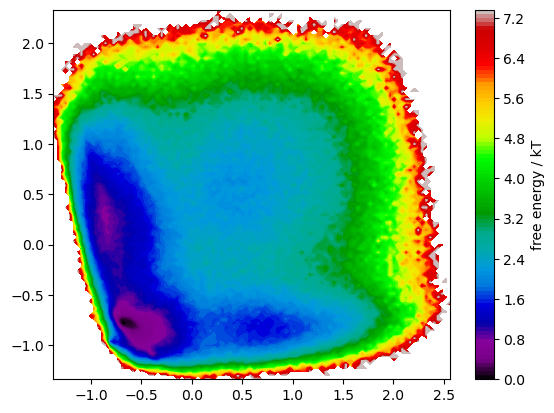

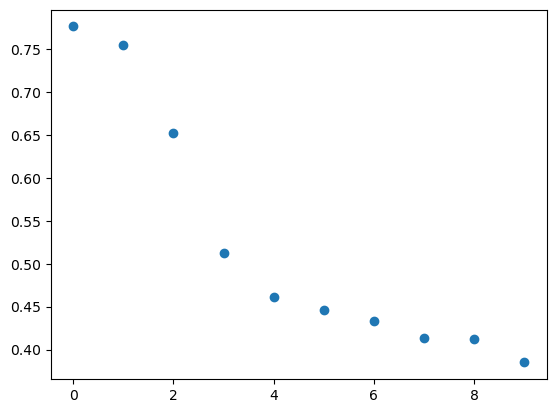

In [8]:
##adjustable params
space = 1
dim = 4
n_clusters = 200
lag = 10
##
combined = dmat
proj_combined, tica_combined = tica(combined,lag, .7)
pyemma.plots.plot_free_energy(*proj_combined[:,:2].T)
plt.figure()
plt.scatter(np.arange(len(tica_combined.singular_values[:10])), tica_combined.singular_values[:10])
dtraj,frames_cl,clustercenters = kmeans(proj_combined[:,:dim], n_clusters)

np.save('lig47_dist_tica_combined_l10_d4.npy', tica_combined)
np.save('lig47_dist_proj_combined_l10_d4.npy', proj_combined)
np.save('lig47_dtraj_combined_l10_d4.npy', dtraj)

In [12]:
c0_i=frames_cl[0]
c1_i=frames_cl[1]
c2_i=frames_cl[2]
c3_i=frames_cl[3]

c0 = c0_i.size
c1 = c1_i.size
c2 = c1_i.size
c3 = c3_i.size
size = [c0, c1, c2, c3]
langs = ['C_1', 'C_2', 'C_3', 'C_4']
plt.bar(langs, size, color = viridis)

NameError: name 'viridis' is not defined

In [43]:
clustercenters

array([[-0.035, -0.152],
       [0.019, 0.131],
       [-0.234, 0.010],
       [0.238, -0.035]])

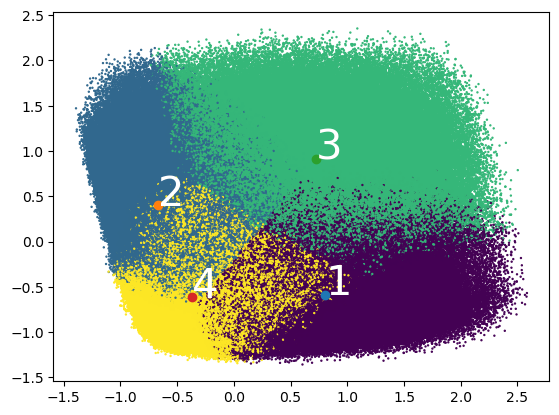

In [10]:
plt.scatter(*proj_combined[:,:2].T, c = dtraj, s=.5)
for j,i in enumerate(clustercenters):
    plt.annotate(f"{j+1}", [i[k] for k in range(2)], color="white", size="30")
    
plt.scatter(clustercenters[0,0], clustercenters[0,1])
plt.scatter(clustercenters[1,0], clustercenters[1,1])
plt.scatter(clustercenters[2,0], clustercenters[2,1])
plt.scatter(clustercenters[3,0], clustercenters[3,1])

/home/apara/miniconda3/envs/pyemma/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/apara/miniconda3/envs/pyemma/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


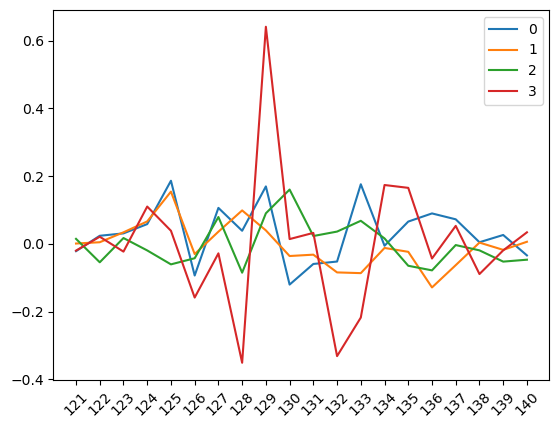

In [47]:
tica_obj = coor.tica(dmat, lag=50)
A = tica_obj.eigenvectors

for i in range(0,4):
 plt.plot(prot_res_renum[0:20],A[:,i],label='%s'%i)

plt.xticks(prot_res,prot_res,rotation=45)
plt.legend()

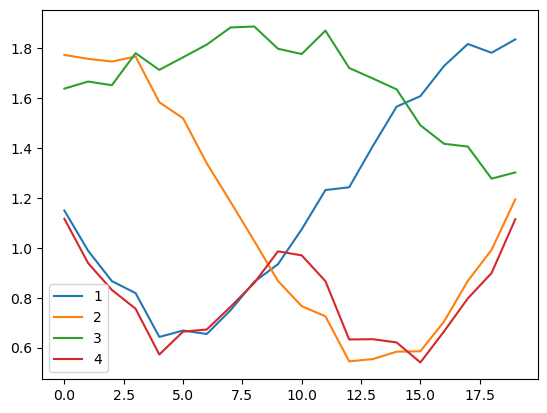

In [11]:
c0_i=frames_cl[0]
c1_i=frames_cl[1]
c2_i=frames_cl[2]
c3_i=frames_cl[3]

plt.plot(np.average(dmat[c0_i],axis=0),label='1')
plt.plot(np.average(dmat[c1_i],axis=0),label='2')
plt.plot(np.average(dmat[c2_i],axis=0),label='3')
plt.plot(np.average(dmat[c3_i],axis=0),label='4')
plt.legend()
#plt.savefig("fasudil_clusters.png")

In [51]:
#contact probabilities
dmat_con_prob = np.sum(dmat_bin, axis =0)/dmat.shape[0]
print (dmat_con_prob)
dmat_con_prob.shape

[0.046 0.065 0.101 0.088 0.175 0.129 0.142 0.115 0.102 0.118 0.119 0.091
 0.199 0.160 0.165 0.214 0.164 0.108 0.126 0.083]


(20,)

In [3]:
!pwd

/home/apara/Documents/asn/tica/lig_47/dist


In [4]:
dtraj = np.load('/home/apara/Documents/asn/tica/lig_47/dist/lig47_dtraj_combined_10.npy')

In [9]:
#make tick labels
ticklabs = "1,2,3,4".split(",")
#make custom set of colors for each state
nstates = dtraj.max()+1
color_list = plt.cm.viridis
cs = [color_list(i) for i in range(color_list.N)]
cmap = colors.ListedColormap(cs)
boundaries = np.arange(nstates+1).tolist()
clist = [cs[int(i)] for i in np.linspace(10,len(cs)-20,nstates)]
clist = clist[::-1]

In [13]:
#make instance of bayesian MSM  to estimate errors from bootstrapping (gibbs sampling)
lagtime = 30
bmsm = pyemma.msm.bayesian_markov_model(dtraj,lagtime,nsamples=10)    
ck = bmsm.cktest(3,memberships = np.eye(nstates),n_jobs=1,)

pyemma.msm.estimators.bayesian_msm.BayesianMSM[10]: Sampling MSMs:   0%|                                      …

estimating BayesianMSM:   0%|                                                                                 …

/home/apara/miniconda3/envs/pyemma/lib/python3.10/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')


In [11]:
#customize pyemma source code
def _add_ck_subplot(cktest, test_index, ax, i, j, ipos=None, jpos=None, y01=True, units='steps', dt=1., **plot_kwargs):
    # plot estimates
    for default in ['color', 'linestyle']:
        if default in plot_kwargs.keys():
            #print("ignoring plot_kwarg %s: %s"%(default, plot_kwargs[default]))
            plot_kwargs.pop(default)
    color = clist[1] ####this is added######

    lest = ax.plot(dt*cktest.lagtimes, cktest.estimates[:, i, j], color="black", **plot_kwargs)
    # plot error of estimates if available
    if cktest.has_errors and cktest.err_est:
        ax.fill_between(dt*cktest.lagtimes, cktest.estimates_conf[0][:, i, j], cktest.estimates_conf[1][:, i, j],
                        color='black', alpha=0.2)
    # plot predictions
    lpred = ax.plot(dt*cktest.lagtimes, cktest.predictions[:, i, j], color=color, linestyle='dashed', **plot_kwargs)
    # plot error of predictions if available
    if cktest.has_errors:
        ax.fill_between(dt*cktest.lagtimes, cktest.predictions_conf[0][:, i, j], cktest.predictions_conf[1][:, i, j],
                        color=color, alpha=0.2)
    # add label
    ax.text(0.1, 0.8, str(i+1)+' ->'+str(j+1), transform=ax.transAxes, weight='bold')
    if y01:
        ax.set_ylim(0, 1)
    # Axes labels
    if ipos is None:
        ipos = i
    if jpos is None:
        jpos = j
    if (jpos == 0):
        ax.set_ylabel('probability')
    if (ipos == cktest.nsets-1):
        ax.set_xlabel('lag time (' + units + ')')
    # return line objects
    return lest, lpred


def plot_cktest(cktest, figsize=None, diag=False,  y01=True, layout=None,
                padding_between=0.1, padding_top=0.075, units='steps', dt=1., **plot_kwargs):
    """Plot of Chapman-Kolmogorov test
    Parameters
    ----------
    cktest : msm.ChapmanKolmogorovValidator or list of msm.ChapmanKolmogorovValidator
        Chapman-Kolmogorov Test, optionally a list of tests which are all 
        plotted into the same set of axes. This assumes that all cktests were
        estimated for the same nstates.
    figsize : shape, default=(10, 10)
        Figure size
    diag : bool, default=False
        Plot only diagonal elements of the test, i.e. self-transition
        probabilities.
    y01 : bool, default=True
        Scale all y-Axes to [0,1]. If True, the y-Axes can be shared
        and the figure is tighter. If False, each y Axis will be scaled
        automatically.
    layout : str or shape or None, default=None
        Organization of subplots. You can specify your own shape. If None,
        an automatic shape will be selected. Use 'wide' for plots that
        span the page width (double-column figures) and 'tall' for
        single-column figures.
    padding_between : float, default=0.1
        padding space between subplots (as a fraction of 1.0)
    padding_top : float, default=0.05
        padding space on top of subplots (as a fraction of 1.0)
    **plot_kwargs : optional keyword arguments for the matplotlib.pylab.plot() call
        The user is allowed to choose values like marker='x', linewidth=3 etc. Note that
        'linestyle' and 'color' are defaults and cannot be changed using plot_kwargs
    Returns
    -------
    fig : Figure object
    axes : Axis objects with subplots
    """
    if not isinstance(cktest, (list, tuple)):
        cktests = [cktest]
    else:
        cktests = cktest
    cktest = cktests[0]
    for test in cktests:
        assert cktest.nsets == test.nsets, "cktests all need same number of sets"
    import matplotlib.pylab as plt
    sharey = y01
    # first fix subfigure layout
    if diag:
        if layout is None or layout == 'wide':
            ncol = min(4, cktest.nsets)
            layout = (int(math.ceil(cktest.nsets / ncol)), ncol)
        elif layout == 'tall':
            nrow = min(4, cktest.nsets)
            layout = (nrow, int(math.ceil(cktest.nsets / nrow)))
    else:
        layout = (cktest.nsets, cktest.nsets)
    # fix figure size
    if figsize is None:
        size_per_subplot = min(3.0, 10.0 / np.max(np.array(layout)))
        figsize = (size_per_subplot*layout[1], size_per_subplot*layout[0])
    # generate subplots
    fig, axes = plt.subplots(layout[0], layout[1], sharex=True, sharey=sharey, figsize=figsize)
    axeslist = list(axes.flatten())
    # line objects
    lest = None
    lpred = None
    # plot
    lests = []
    lpreds = []
    for test_index, test in enumerate(cktests):
        for (k, ax) in enumerate(axeslist):
            if diag and k < cktest.nsets:
                ipos = int(k/layout[1])
                jpos = int(k%layout[1])
                lest, lpred = _add_ck_subplot(test, test_index, ax, k, k, ipos=ipos, jpos=jpos, y01=y01, units=units,
                                              dt=dt, **plot_kwargs)
                k += 1
            else:
                i = int(k/cktest.nsets)
                j = int(k%cktest.nsets)
                lest, lpred = _add_ck_subplot(test, test_index, ax, i, j, y01=y01, units=units, dt=dt, **plot_kwargs)
        lests.append(lest[0])
        lpreds.append(lpred[0])
    # figure legend
    handles = []
    labels = []
    for ix, test in enumerate(cktests):
        predlabel = 'predict {}'.format(ix) if len(cktests) > 1 else 'predict'
        estlabel = 'estimate {}'.format(ix) if len(cktests) > 1 else 'estimate'
        if cktest.has_errors:
            predlabel += '     conf. {:3.1f}%'.format(100.0*cktest.conf)
        handles.append(lests[ix])
        handles.append(lpreds[ix])
        labels.append(predlabel)
        labels.append(estlabel)
    fig.legend(handles, labels, 'upper center', ncol=2, frameon=False,prop={'size': 15})
    # change subplot padding
    plt.subplots_adjust(top=1.0-padding_top, wspace=padding_between, hspace=padding_between)
    # done
    return fig, axes


KeyboardInterrupt



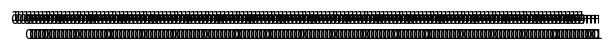

In [12]:
#plot customized CK plot
fig, ax =plot_cktest(ck,figsize=(10,10),padding_top= .05,units = "ns", dt = .2,
                                  padding_between = 0.2, y01=True,layout="wide")
for axi in ax.flat:
    axi.set_xlabel(None)
    axi.set_ylabel(None)
fig.supxlabel("lagtime (ns)",x=0.5,y=.05,size = 20)
fig.supylabel("Probability",x=.05,y=.5,size = 20)

In [14]:
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales

In [26]:
its_data = implied_timescales(bmsm)

Text(0, 0.5, 'timescale (steps)')

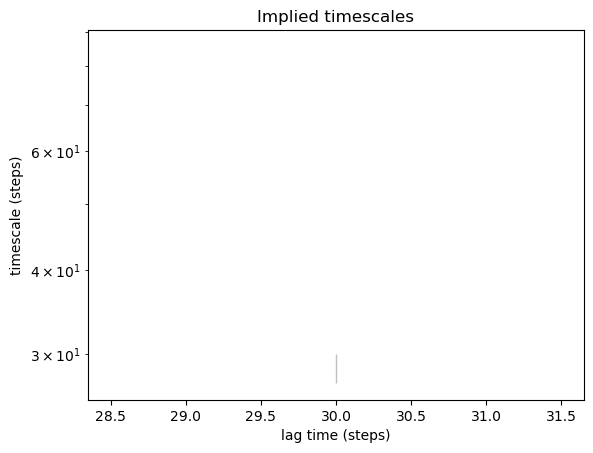

In [29]:
fig, ax = plt.subplots(1, 1)
plot_implied_timescales(its_data, n_its=2, ax=ax)
ax.set_yscale('log')
ax.set_title('Implied timescales')
ax.set_xlabel('lag time (steps)')
ax.set_ylabel('timescale (steps)')

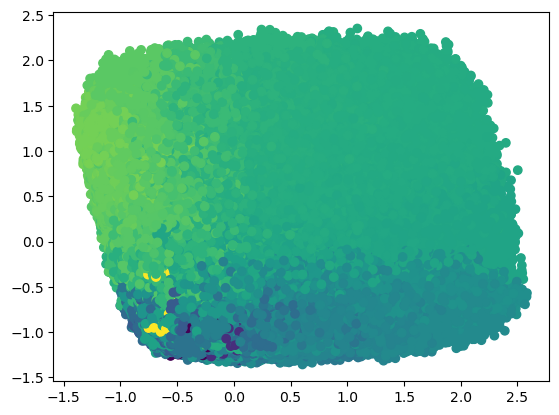

In [31]:
plt.scatter(*proj_combined[:, :2].T, c=bmsm.eigenvectors_right()[:, 3][dtraj])

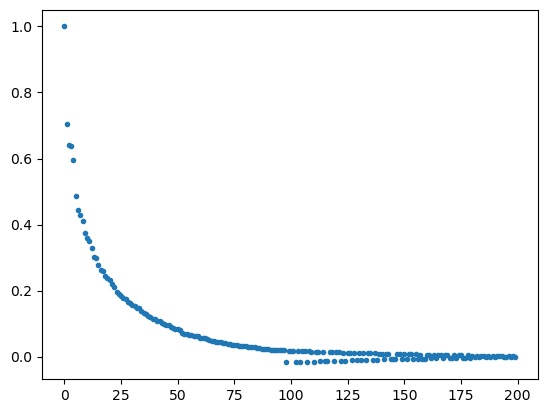

In [25]:
plt.plot(bmsm.eigenvalues(), '.')

In [20]:
dtraj.shape

(1100889,)

In [17]:
#customize pyemma source code
from pyemma.util.statistics import confidence_interval as _conf
from pyemma.util.types import is_iterable_of_int as _is_iterable_of_int, is_int as _is_int
import numpy as _np
__author__ = 'noe'


def plot_implied_timescales(ITS, ax=None, outfile=None, show_mle=True, show_mean=True,
                            xlog=False, ylog=True, confidence=0.95, refs=None, nits=-1,
                            process=None, units='steps', dt=1., **kwargs):
    r"""Implied timescale plot
    Parameters
    ----------
    ITS : implied timescales object.
        Object whose data will be plotted. Should be of type :class:`ImpliedTimescales <pyemma.msm.ImpliedTimescales>`
        or a 3-tuple with: 1d array of lagtimes, (lagtimes, processes) array of timescales,
        optionally (lagtimes, processes, samples) array of timescales of samples.
    ax : matplotlib Axes object, optional, default = None
        the axes to plot to. When set to None the default Axes object will be used.
    outfile : str, optional, default = None
        output file to write the figure to. When not given, the plot will be displayed
    show_mean : bool, default = True
        Line for mean value will be shown, if available
    show_mle : bool, default = True
        Line for maximum likelihood estimate will be shown
    xlog : bool, optional, default = False
        Iff true, the x-Axis is logarithmized
    ylog : bool, optional, default = True
        Iff true, the y-Axis is logarithmized
    confidence : float, optional, default = 0.95
        The confidence interval for plotting error bars (if available)
    refs : ndarray((m), dtype=float), optional, default = None
        Reference (exact solution or other reference) timescales if known. The number of timescales must match those
        in the ITS object
    nits: integer, default = -1
        Number of implied timescales to be shown. The default behaviour (-1) is to show all timescales available.
        :py:obj:`nits` != -1 and :py:obj:`process` != None are mutually exclusive
    process : iterable of integers, default is None
        list or ndarray((m), dtype=int) containing a list of the processes to be shown. The default behaviour is
        to show all timescales available.
        :py:obj:`process` != None and :py:obj:`nits` != -1 are mutually exclusive
    units: str or list (len=2) of strings, optional, default = 'steps'
        Affects the labeling of the axes. Used with :py:obj:`dt`, allows for changing the physical units of the axes.
        Accepts simple LaTeX math strings, eg. '$\mu$s'
        If this parameter is a list, it will be assumed that units[0] is for the x-axis and units[1] for the y-axis.
    dt: float or list(len=2) of floats, optional, default = 1.0
        Physical time between frames, expressed the units given in :py:obj:`units`. E.g, if you know that each
        frame corresponds to .010 ns, you can use the combination of parameters :py:obj:`dt` =0.01,
        :py:obj:`units` ='ns' to display the implied timescales in ns (instead of frames)
        If this parameter is a list, it will be assumed that dt[0] is for the x-axis and dt[1] for the y-axis.
    **kwargs: Will be passed to pyplot.plot when plotting the MLE datapoints (not the bootstrapped means).
            See the doc of pyplot for more options. Most useful lineproperties like `marker='o'` and/or :markersize=5
    Returns
    -------
    ax : Axes object containing the plot
    """
    if isinstance(ITS, tuple):
        assert len(ITS) in (2, 3)
        lags = _np.asarray(ITS[0])
        timescales = _np.asarray(ITS[1])
        timescales_samples = _np.asarray(ITS[2]) if len(ITS) == 3 and ITS[2] is not None else None
        n_timescales = timescales.shape[1]
        samples_available = timescales_samples is not None
    else:
        lags = ITS.lagtimes
        n_timescales = ITS.number_of_timescales
        timescales = ITS.get_timescales()
        samples_available = ITS.samples_available
        timescales_samples = ITS.timescales_samples
        if timescales_samples is not None:
            timescales_samples = timescales_samples.transpose(1, 2, 0)
    import matplotlib.pyplot as _plt
    # check input
    if ax is None:
        ax = _plt.gca(figsize= (10,6))
    colors = clist ######ADDED#####
    xmax = _np.max(lags)
    srt = _np.argsort(lags)
    # Check the processes to be shown
    if process is not None:
        if nits != -1:
            raise TypeError(
                'optional arguments nits and process are mutually exclusive:', nits, process)
        if not _is_iterable_of_int(process):
            raise ValueError('process has to be an iterable of integers')
        if _np.max(process)+1 > n_timescales:
            raise ValueError(
                'requested process %u, whereas ITS only contains %u timescales' % (
                    _np.max(process), n_timescales))
        # Now that it's for sure that nits==-1,
        # process is iter_of_ints, and the requested processes exist in its object:
        its_idx = process
    else:
        if not _is_int(nits):
            raise TypeError('nits is not an integer, ',nits)
        if nits == -1:
            nits = n_timescales
        its_idx = _np.arange(n_timescales)[:nits]
    # Check units and dt for user error.
    if isinstance(units, list) and len(units) != 2:
        raise TypeError("If units is a list, len(units) has to be = 2")
    if isinstance(dt, list) and len(dt) != 2:
        raise TypeError("If dt is a list, len(dt) has to be = 2")
    # Create list of units and dts for different axis
    if isinstance(units, str):
        units = [units] * 2
    if isinstance(dt, (float, int)):
        dt = [dt] * 2
    for i in its_idx:
        # plot estimate
        if show_mle:
            ax.plot(
                lags[srt] * dt[0], timescales[..., i][srt] * dt[1],
                color=colors[i % len(colors)], **kwargs)
        # sample available?
        if samples_available:
            # plot sample mean
            process_samples = timescales_samples[:, i, :].T
            if show_mean:
                sample_mean = _np.mean(process_samples, axis=0)
                ax.plot(
                    lags[srt] * dt[0], sample_mean[srt] * dt[1], marker='o',
                    color=colors[i % len(colors)], linestyle='dashed')
            lconf, rconf = _conf(process_samples, conf=confidence)
            ax.fill_between(
                lags[srt] * dt[0], lconf[srt] * dt[1], rconf[srt] * dt[1],
                alpha=0.2, color=colors[i % len(colors)])
        # reference available?
        if refs is not None:
            tref = refs[i] * dt[1]
            ax.plot([0, min(tref, xmax) * dt[0]], [tref, tref], color='black', linewidth=1)
    # cutoff
    ax.plot(lags[srt] * dt[0], lags[srt] * dt[1], linewidth=2, color='black')
    ax.set_xlim([1.0 * dt[0], xmax * dt[0]])
    ax.fill_between(
        lags[srt] * dt[0], ax.get_ylim()[0]*_np.ones(len(lags))*dt[1], lags[srt] * dt[1],
        alpha=0.2, color='grey')
    # formatting
    ax.set_xlabel('lag time / %s' % units[0])
    ax.set_ylabel('timescale / %s' % units[1])
    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
    # show or save
    if outfile is not None:
        _plt.savefig(outfile)
    return ax

estimating BayesianMSM:   0%|                            | 0/29 [00:00<?, ?it/s]

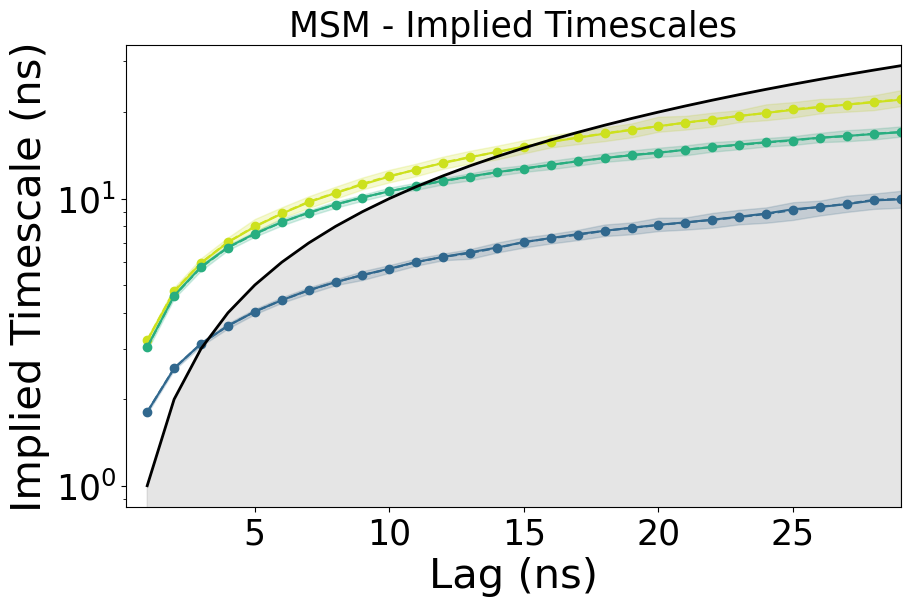

In [18]:
its = pyemma.msm.its(dtraj,np.arange(5,150,5),nits=nstates-1, errors="bayes", nsamples = 100,
                    n_jobs=1, )
fig,ax = plt.subplots(1,figsize=(10,6))
plot_implied_timescales(its,units="ns", dt=.2,ax=ax)
ax.set_xlabel("Lag (ns)",size=30)
ax.set_ylabel("Implied Timescale (ns)",size=30)
ax.set_title("MSM - Implied Timescales",size=25)
ax.tick_params("both", labelsize=25)

In [19]:
#stationary distribution errors
stat_error_l,stat_error_r = bmsm.sample_conf("stationary_distribution") #this estimate has the mean added to it
#above is a computation of the 95% confidence interval
stat_dist_mean = bmsm.sample_mean("stationary_distribution")
stat_dist_error = abs(np.stack([stat_error_l,stat_error_r]) - stat_dist_mean)

(0.5, 4.5)

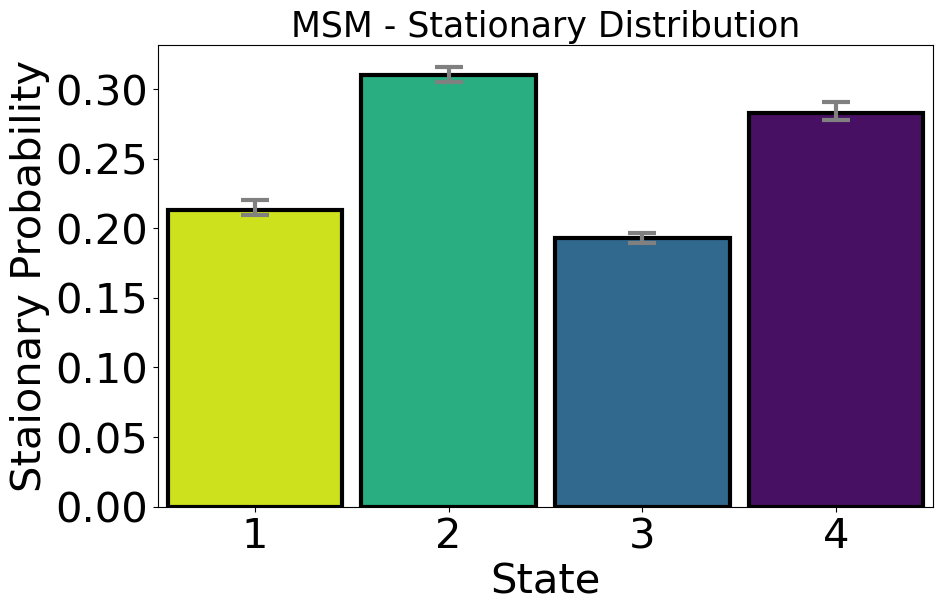

In [20]:
plt.figure(figsize = (10,6))
plt.bar(np.arange(1,nstates+1),stat_dist_mean,yerr = stat_dist_error,
        ecolor="grey",color=clist,capsize=10,width=.9,linewidth=3, edgecolor = "black",
        align="center",error_kw=dict(capthick=3,lw=3))
plt.xticks(np.arange(1,nstates+1), ticklabs)
plt.xlabel("State", size=30)
plt.ylabel("Staionary Probability", size=30)
plt.title("MSM - Stationary Distribution",size=25)
plt.xticks(size = 30)
plt.yticks(size = 30)
plt.xlim(.5,nstates+.5)

In [21]:
def plot_mat_error(mat,emat,title,unit,cbarlabel,
                   textsize,textcolor,cmap,ticklabs):
        """mat = square matrix
        unit = string specifying the units"""
        fig,ax = plt.subplots(1,figsize=(20,20))
        s = ax.imshow(mat, cmap=cmap)
        for i in range(len(mat)):
            for j in range(len(mat)):
                c = mat[j, i]
                e = emat[j,i]
                ax.text(i, j,f"{np.round(c,1)}$\pm${np.round(e,2)}{unit}",
                        va='center', ha='center', color = textcolor,size=textsize,weight="bold")
        ax.set_yticks(list(range(len(mat))), ticklabs,size=35)
        ax.set_xticks(list(range(len(mat))), ticklabs,size=35)
        ax.set_ylabel(r"$State_{i}$", size=45)
        ax.set_xlabel(r"$State_{j}$", size=45)
        cb = plt.colorbar(s,ax=ax,label=cbarlabel,fraction=0.046,pad=0.04)
        cb.set_label(cbarlabel, size=40)
        cb.ax.tick_params(labelsize=30)
        ax.set_title(title, size = 45)
        plt.show()
        return

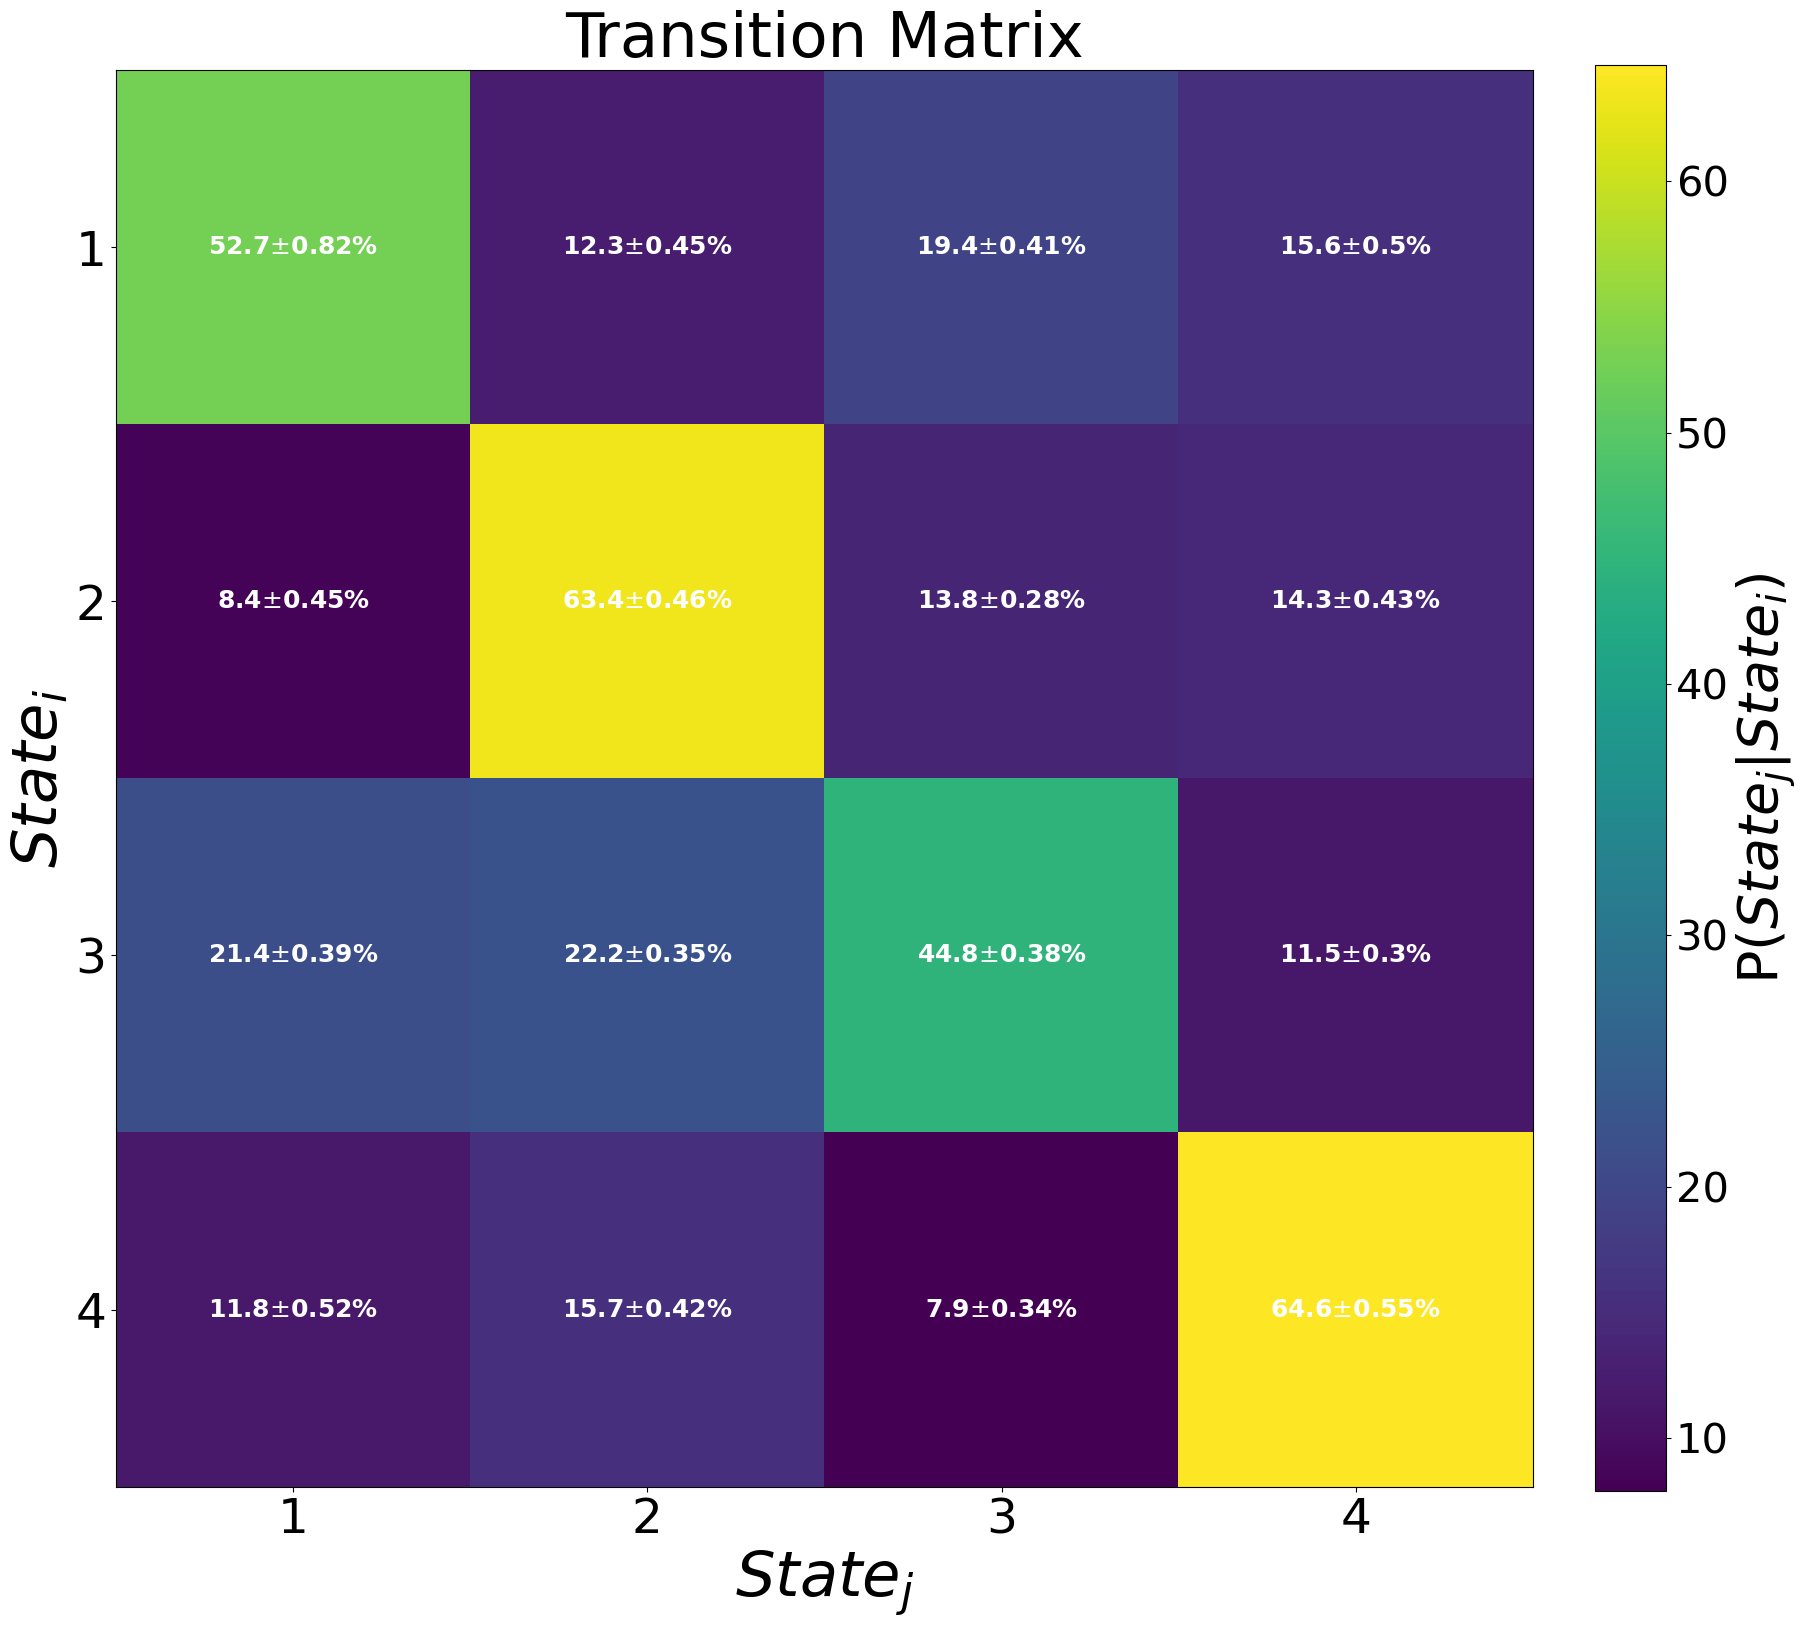

In [22]:
#transition matrix errors
tmat_l,tmat_r = bmsm.sample_conf("transition_matrix")
tmat = bmsm.sample_mean("transition_matrix")
rel_tmat_error = (abs(tmat-tmat_l)+abs(tmat-tmat_r))/2
tmat *= 100
rel_tmat_error *= 100

plot_mat_error(tmat,rel_tmat_error,"Transition Matrix","%",
               r"P($State_{j}$|$State_{i}$)",18,"white","viridis",ticklabs )

/home/apara/miniconda3/envs/pyemma/lib/python3.10/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')


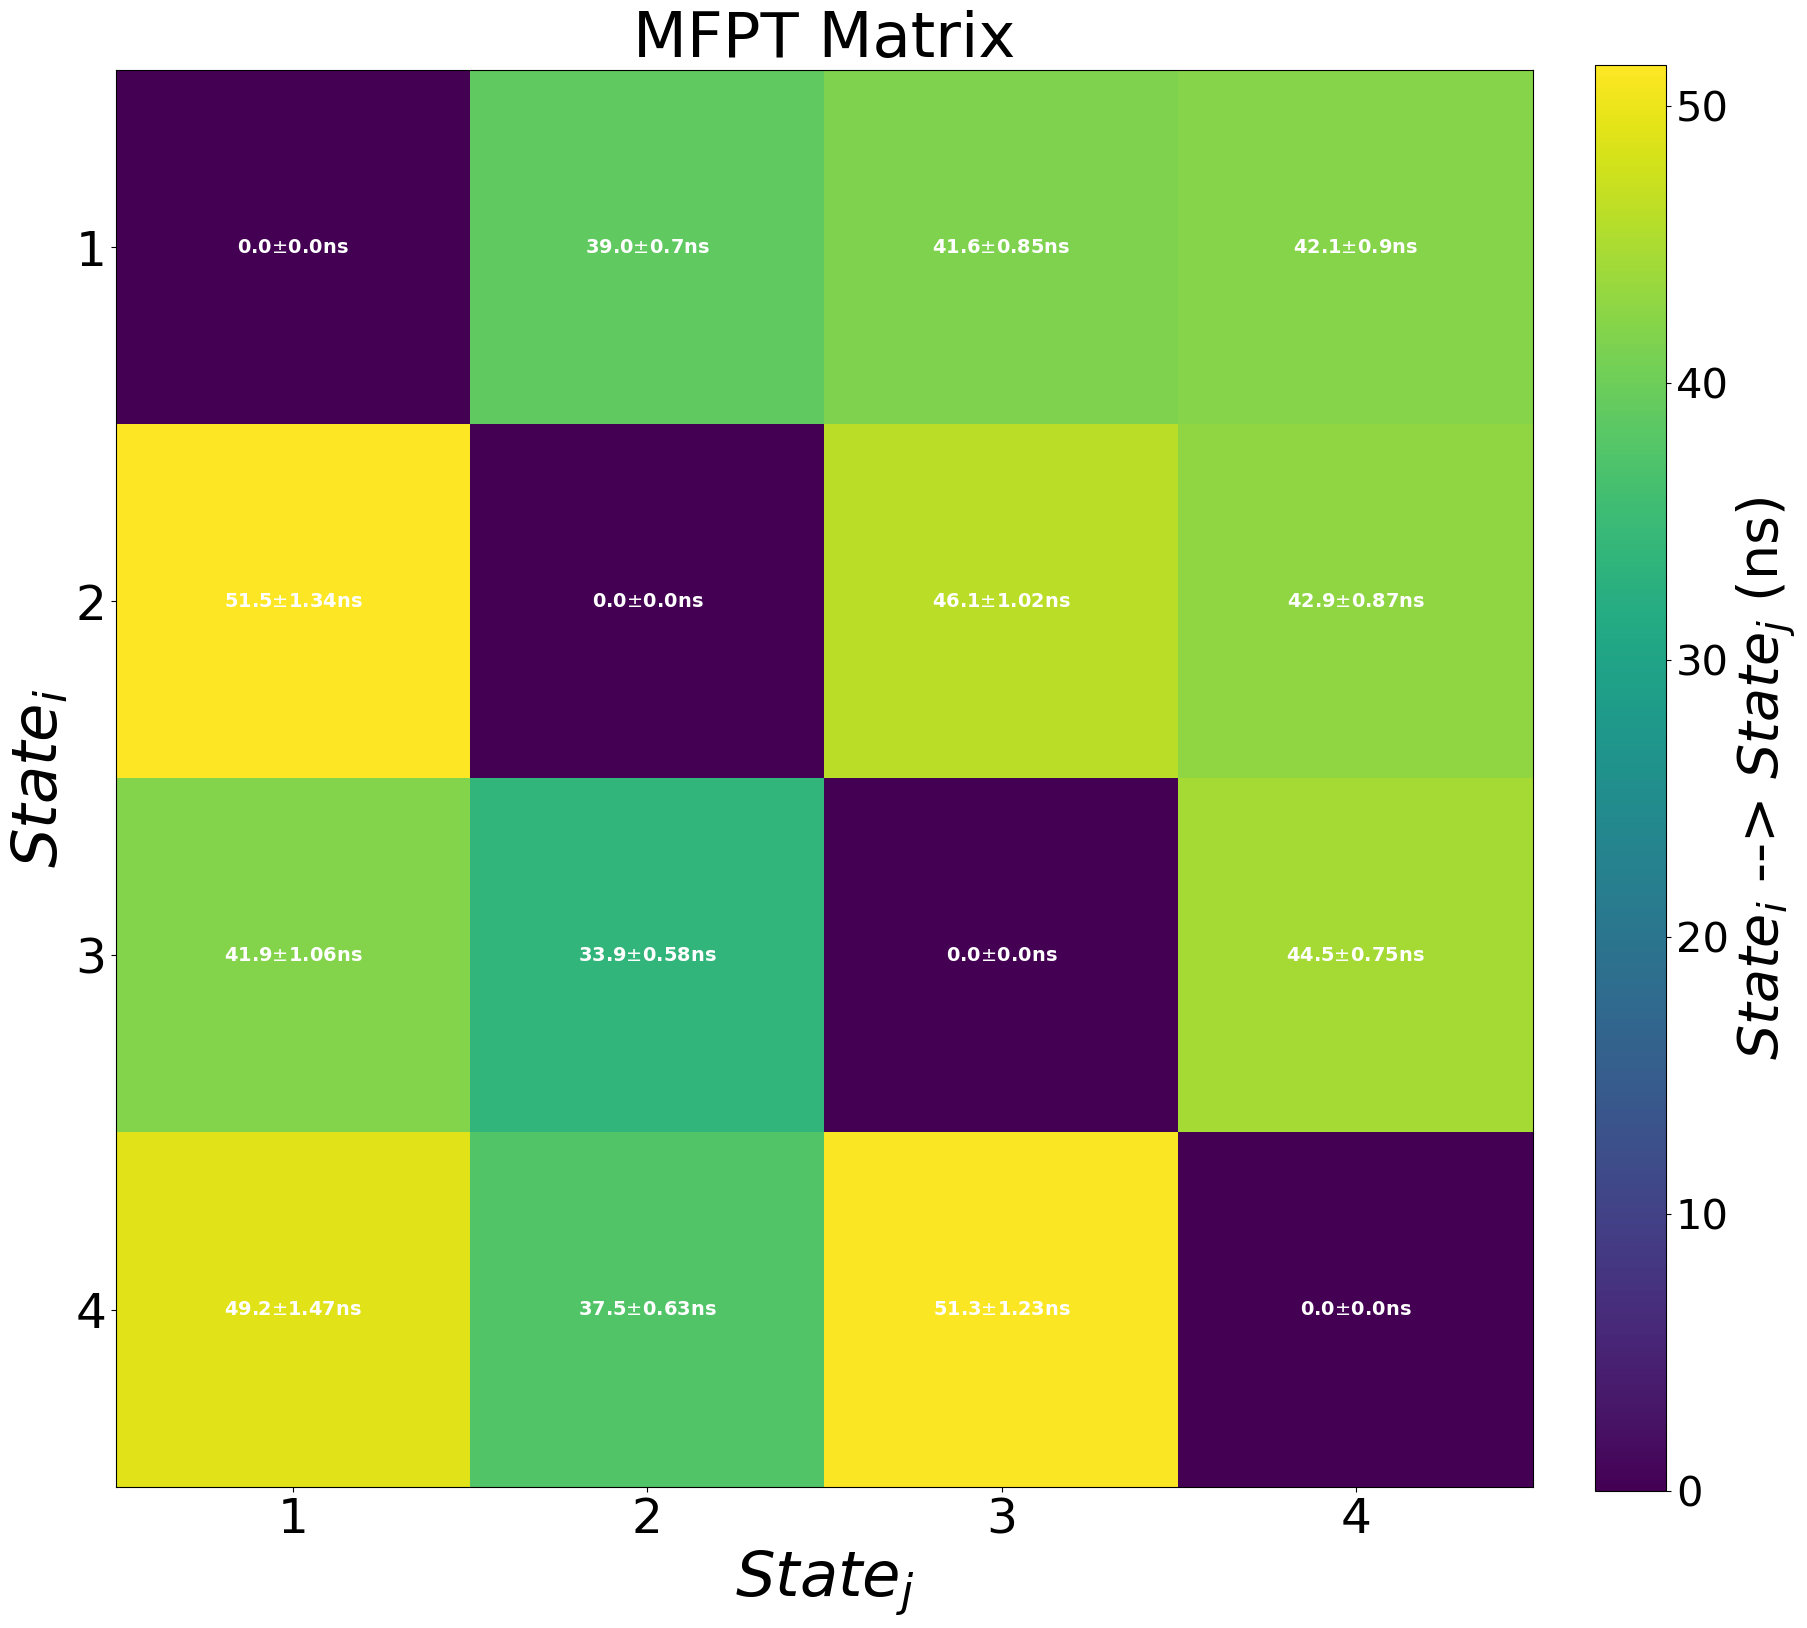

In [23]:
mfpt_error = np.zeros((nstates,nstates))
mfpt_mean = np.zeros((nstates,nstates))
for i in range(nstates):
    for j in range(nstates):
        mean = bmsm.sample_mean("mfpt", i,j)*(.2)
        mfpt_mean[i,j] = mean
        l,r = np.array(bmsm.sample_conf("mfpt", i,j))*(.2)
        mfpt_error[i,j] = (abs(mean-r)+abs(mean-l))/2
        
        
plot_mat_error(mfpt_mean,mfpt_error,"MFPT Matrix","ns",r"$State_{i}$ --> $State_{j}$ (ns)",
         14,"white","viridis",ticklabs)

In [17]:
def makem(ddtraj,nsets,lag):
    msm = pyemma.msm.estimate_markov_model(ddtraj, lag=lag)
    print(msm.score(ddtraj))
    #pyemma.plots.plot_cktest(msm.cktest(nsets=nsets,memberships=np.eye(nsets)))
    #plt.tight_layout()
    #plt.figure()
    lags_scale = np.arange(1,20)
    #its = pyemma.msm.its(ddtraj,lags = lags_scale, nits=nsets-1,errors = None)
    #pyemma.plots.plot_implied_timescales(its)
    return msm

In [18]:
#dmat
msm = makem(dtraj, 4, 10)

06-12-22 16:19:26 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[0] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4
2.100773130733625


([<matplotlib.axis.XTick at 0x7ff9a4e0ec80>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

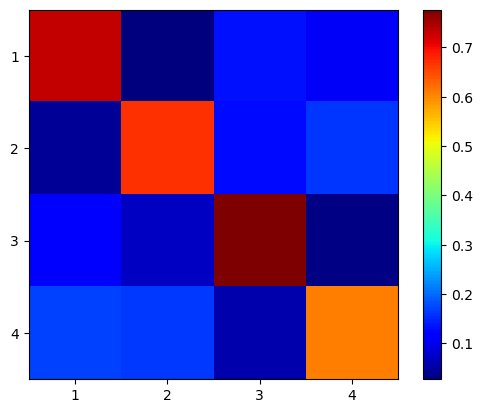

In [19]:
plt.imshow(msm.transition_matrix,cmap = "jet")
plt.colorbar()
plt.yticks(np.arange(4),np.arange(1,5))
plt.xticks(np.arange(4),np.arange(1,5))

In [20]:
print("mfpt 0-1 is", (msm.mfpt(0, 1)))
print("mfpt 0-2 is", (msm.mfpt(0, 2)))
print("mfpt 0-3 is", (msm.mfpt(0, 3)))
print("mfpt 1-0 is", (msm.mfpt(1, 0)))
print("mfpt 1-2 is", (msm.mfpt(1, 2)))
print("mfpt 1-3 is", (msm.mfpt(1, 3)))
print("mfpt 2-0 is", (msm.mfpt(2, 0)))
print("mfpt 2-1 is", (msm.mfpt(2, 1)))
print("mfpt 2-3 is", (msm.mfpt(2, 3)))
print("mfpt 3-0 is", (msm.mfpt(3, 0)))
print("mfpt 3-1 is", (msm.mfpt(3, 1)))
print("mfpt 3-2 is", (msm.mfpt(3, 2)))

mfpt 0-1 is 154.30598684134006
mfpt 0-2 is 86.40510485920878
mfpt 0-3 is 116.6878061126279
mfpt 1-0 is 105.54680601862707
mfpt 1-2 is 90.3366213292815
mfpt 1-3 is 98.64048143109682
mfpt 2-0 is 90.75980488162153
mfpt 2-1 is 143.4505021744073
mfpt 2-3 is 138.80332034418484
mfpt 3-0 is 83.09092390745244
mfpt 3-1 is 113.8027800486344
mfpt 3-2 is 100.8517381165966


In [21]:
#dmat
msm = makem(dtraj, 4, 50)

06-12-22 16:19:28 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[1] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4
1.3799577179935347


([<matplotlib.axis.XTick at 0x7ff9a4c54d00>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

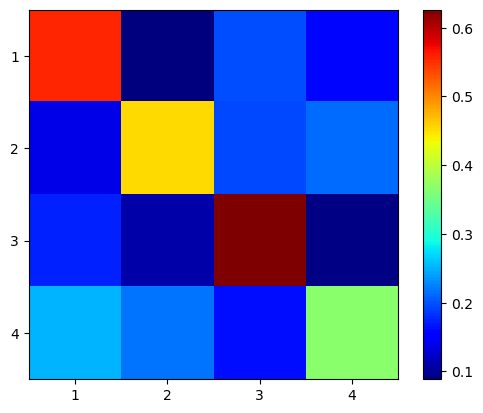

In [22]:
plt.imshow(msm.transition_matrix,cmap = "jet")
plt.colorbar()
plt.yticks(np.arange(4),np.arange(1,5))
plt.xticks(np.arange(4),np.arange(1,5))

In [23]:
print("mfpt 0-1 is", (msm.mfpt(0, 1)))
print("mfpt 0-2 is", (msm.mfpt(0, 2)))
print("mfpt 0-3 is", (msm.mfpt(0, 3)))
print("mfpt 1-0 is", (msm.mfpt(1, 0)))
print("mfpt 1-2 is", (msm.mfpt(1, 2)))
print("mfpt 1-3 is", (msm.mfpt(1, 3)))
print("mfpt 2-0 is", (msm.mfpt(2, 0)))
print("mfpt 2-1 is", (msm.mfpt(2, 1)))
print("mfpt 2-3 is", (msm.mfpt(2, 3)))
print("mfpt 3-0 is", (msm.mfpt(3, 0)))
print("mfpt 3-1 is", (msm.mfpt(3, 1)))
print("mfpt 3-2 is", (msm.mfpt(3, 2)))

mfpt 0-1 is 424.79885118329054
mfpt 0-2 is 265.0053722273898
mfpt 0-3 is 347.2867954736132
mfpt 1-0 is 288.30688594066504
mfpt 1-2 is 267.03534796699876
mfpt 1-3 is 316.871142398777
mfpt 2-0 is 278.9683883363007
mfpt 2-1 is 417.4903293185352
mfpt 2-3 is 387.7662159143391
mfpt 3-0 is 249.92007484950966
mfpt 3-1 is 355.996387017299
mfpt 3-2 is 276.4364791813248


In [24]:
#dmat
msm = makem(dtraj, 4, 100)

06-12-22 16:19:28 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[2] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4
1.1700818546130167


([<matplotlib.axis.XTick at 0x7ff9a4cf5030>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

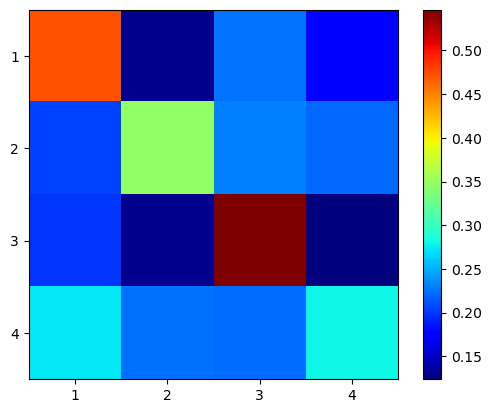

In [25]:
plt.imshow(msm.transition_matrix,cmap = "jet")
plt.colorbar()
plt.yticks(np.arange(4),np.arange(1,5))
plt.xticks(np.arange(4),np.arange(1,5))

In [26]:
print("mfpt 0-1 is", (msm.mfpt(0, 1)))
print("mfpt 0-2 is", (msm.mfpt(0, 2)))
print("mfpt 0-3 is", (msm.mfpt(0, 3)))
print("mfpt 1-0 is", (msm.mfpt(1, 0)))
print("mfpt 1-2 is", (msm.mfpt(1, 2)))
print("mfpt 1-3 is", (msm.mfpt(1, 3)))
print("mfpt 2-0 is", (msm.mfpt(2, 0)))
print("mfpt 2-1 is", (msm.mfpt(2, 1)))
print("mfpt 2-3 is", (msm.mfpt(2, 3)))
print("mfpt 3-0 is", (msm.mfpt(3, 0)))
print("mfpt 3-1 is", (msm.mfpt(3, 1)))
print("mfpt 3-2 is", (msm.mfpt(3, 2)))

mfpt 0-1 is 682.6108542102244
mfpt 0-2 is 442.5758946488416
mfpt 0-3 is 608.7556008577037
mfpt 1-0 is 461.663307852575
mfpt 1-2 is 440.36591057711894
mfpt 1-3 is 572.1130895750415
mfpt 2-0 is 469.47025525632785
mfpt 2-1 is 688.2078175422547
mfpt 2-3 is 652.6505852336281
mfpt 3-0 is 427.22475788556216
mfpt 3-1 is 611.5297929605493
mfpt 3-2 is 444.2253816540004


In [27]:
trj[frames_cl[0]].save_dcd("/home/apara/Documents/asn/tica/lig_47/dist/lig47_cluster_1.dcd") #save frames
trj[frames_cl[1]].save_dcd("/home/apara/Documents/asn/tica/lig_47/dist/lig47_cluster_2.dcd") #save frames
trj[frames_cl[2]].save_dcd("/home/apara/Documents/asn/tica/lig_47/dist/lig47_cluster_3.dcd") #save frames
trj[frames_cl[3]].save_dcd("/home/apara/Documents/asn/tica/lig_47/dist/lig47_cluster_4.dcd") #save frames

[[0.780 0.699 0.750 ... 0.060 0.303 0.038]
 [0.689 0.636 0.727 ... 0.039 0.254 0.043]
 [0.825 0.776 0.786 ... 0.048 0.359 0.048]
 ...
 [0.010 0.014 0.099 ... 0.941 0.911 0.834]
 [0.009 0.026 0.034 ... 0.943 0.956 0.873]
 [0.008 0.005 0.018 ... 0.933 0.875 0.893]]


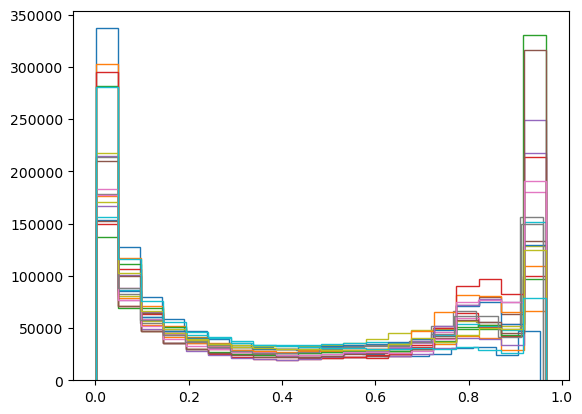

In [28]:
#dists = np.arange(0, 10, 0.1)
def sigmoid(x):
    z = np.exp((-4*x+4))
    sig = 1- 1 / (1 + z)
    return sig

dmat_sig=sigmoid(dmat)

for i in range(0,20):
   plt.hist((dmat_sig[:,i]),histtype='step',bins=20,label=i) 

print (dmat_sig)

<Figure size 640x480 with 0 Axes>

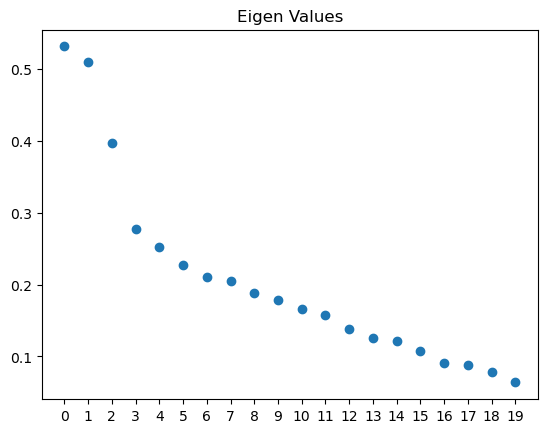

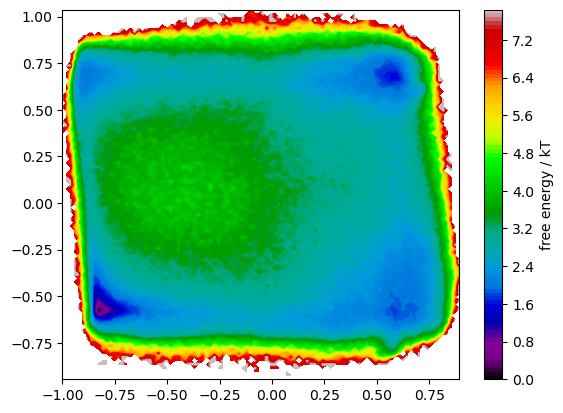

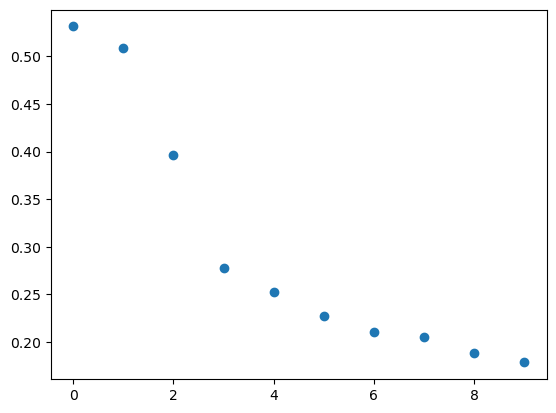

<Figure size 640x480 with 0 Axes>

In [29]:
##adjustable params
space = 1
dim = 2
n_clusters = 4
lag = 50
##
combined = dmat_sig
proj_combined, tica_combined = tica(combined,lag, .7)
pyemma.plots.plot_free_energy(*proj_combined[:,:2].T)
plt.figure()
plt.scatter(np.arange(len(tica_combined.singular_values[:10])), tica_combined.singular_values[:10])
dtraj,frames_cl,clustercenters = kmeans(proj_combined[:,:dim], n_clusters)
plt.figure()


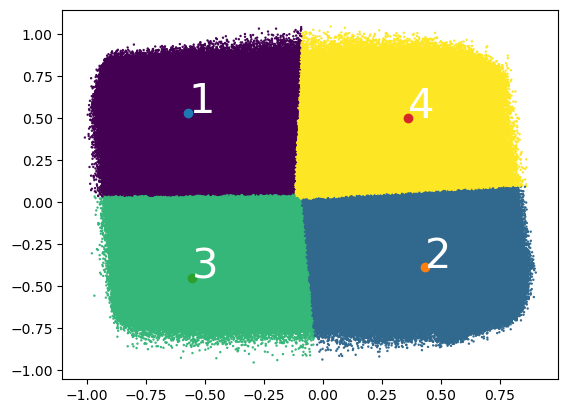

In [30]:
plt.scatter(*proj_combined[:,:2].T, c = dtraj, s=.5)
for j,i in enumerate(clustercenters):
    plt.annotate(f"{j+1}", [i[k] for k in range(2)], color="white", size="30")
#plt.savefig("fasudil_sig_cluster_1")

plt.scatter(clustercenters[0,0], clustercenters[0,1])
plt.scatter(clustercenters[1,0], clustercenters[1,1])
plt.scatter(clustercenters[2,0], clustercenters[2,1])
plt.scatter(clustercenters[3,0], clustercenters[3,1])

/home/apara/miniconda3/envs/pyemma/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/apara/miniconda3/envs/pyemma/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


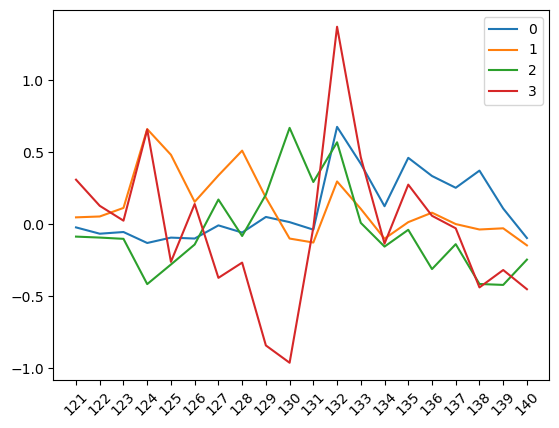

In [31]:
tica_obj = coor.tica(dmat_sig, lag=10)
A = tica_obj.eigenvectors

for i in range(0,4):
 plt.plot(prot_res_renum[0:20],A[:,i],label='%s'%i)

plt.xticks(prot_res,prot_res,rotation=45)
plt.legend()

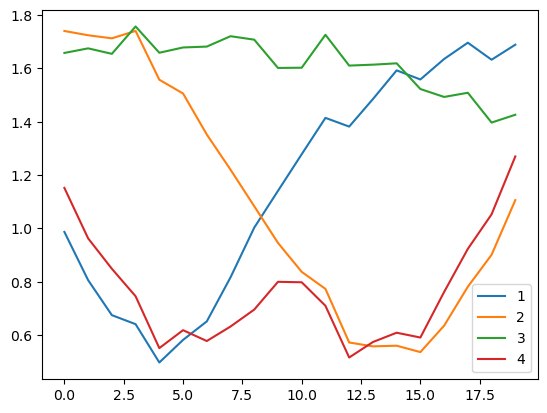

In [32]:
c0_i=frames_cl[0]
c1_i=frames_cl[1]
c2_i=frames_cl[2]
c3_i=frames_cl[3]

plt.plot(np.average(dmat[c0_i],axis=0),label='1')
plt.plot(np.average(dmat[c1_i],axis=0),label='2')
plt.plot(np.average(dmat[c2_i],axis=0),label='3')
plt.plot(np.average(dmat[c3_i],axis=0),label='4')
plt.legend()
#plt.savefig("fasudil_sig_cluster")

In [33]:
def makem(ddtraj,nsets,lag):
    msm = pyemma.msm.estimate_markov_model(ddtraj, lag=lag)
    print(msm.score(ddtraj))
    #pyemma.plots.plot_cktest(msm.cktest(nsets=nsets,memberships=np.eye(nsets)))
    #plt.tight_layout()
    #plt.figure()
    lags_scale = np.arange(1,20)
    #its = pyemma.msm.its(ddtraj,lags = lags_scale, nits=nsets-1,errors = None)
    #pyemma.plots.plot_implied_timescales(its)
    return msm

In [34]:
#dmat_sig
msm = makem(dtraj, 4, 10)

06-12-22 16:19:58 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[6] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4
2.2558003600354657


([<matplotlib.axis.XTick at 0x7ff9a4859e70>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

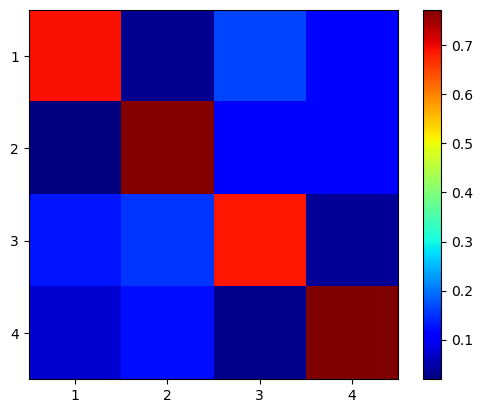

In [35]:
plt.imshow(msm.transition_matrix,cmap = "jet")
plt.colorbar()
plt.yticks(np.arange(4),np.arange(1,5))
plt.xticks(np.arange(4),np.arange(1,5))

In [36]:
print("mfpt 0-1 is", (msm.mfpt(0, 1)))
print("mfpt 0-2 is", (msm.mfpt(0, 2)))
print("mfpt 0-3 is", (msm.mfpt(0, 3)))
print("mfpt 1-0 is", (msm.mfpt(1, 0)))
print("mfpt 1-2 is", (msm.mfpt(1, 2)))
print("mfpt 1-3 is", (msm.mfpt(1, 3)))
print("mfpt 2-0 is", (msm.mfpt(2, 0)))
print("mfpt 2-1 is", (msm.mfpt(2, 1)))
print("mfpt 2-3 is", (msm.mfpt(2, 3)))
print("mfpt 3-0 is", (msm.mfpt(3, 0)))
print("mfpt 3-1 is", (msm.mfpt(3, 1)))
print("mfpt 3-2 is", (msm.mfpt(3, 2)))

mfpt 0-1 is 111.9743601333202
mfpt 0-2 is 91.1353482751282
mfpt 0-3 is 119.79720308860675
mfpt 1-0 is 176.38208922941405
mfpt 1-2 is 109.09099794684992
mfpt 1-3 is 118.69222386106635
mfpt 2-0 is 134.01995231434805
mfpt 2-1 is 87.56787288997599
mfpt 2-3 is 138.19491014650097
mfpt 3-0 is 157.44791941894348
mfpt 3-1 is 91.93521109530926
mfpt 3-2 is 132.96102243761783


In [37]:
#dmat
msm = makem(dtraj, 4, 50)

06-12-22 16:19:59 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[7] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4
1.4590146022805652


([<matplotlib.axis.XTick at 0x7ff9a48e5720>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

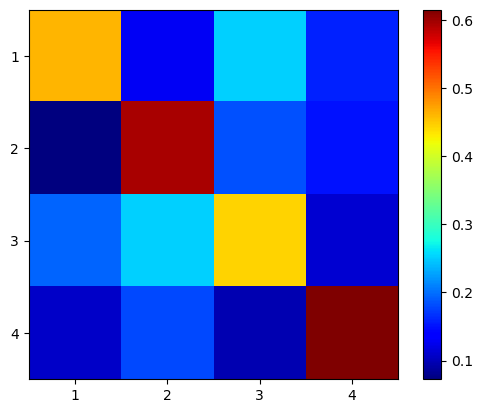

In [38]:
plt.imshow(msm.transition_matrix,cmap = "jet")
plt.colorbar()
plt.yticks(np.arange(4),np.arange(1,5))
plt.xticks(np.arange(4),np.arange(1,5))

In [39]:
print("mfpt 0-1 is", (msm.mfpt(0, 1)))
print("mfpt 0-2 is", (msm.mfpt(0, 2)))
print("mfpt 0-3 is", (msm.mfpt(0, 3)))
print("mfpt 1-0 is", (msm.mfpt(1, 0)))
print("mfpt 1-2 is", (msm.mfpt(1, 2)))
print("mfpt 1-3 is", (msm.mfpt(1, 3)))
print("mfpt 2-0 is", (msm.mfpt(2, 0)))
print("mfpt 2-1 is", (msm.mfpt(2, 1)))
print("mfpt 2-3 is", (msm.mfpt(2, 3)))
print("mfpt 3-0 is", (msm.mfpt(3, 0)))
print("mfpt 3-1 is", (msm.mfpt(3, 1)))
print("mfpt 3-2 is", (msm.mfpt(3, 2)))

mfpt 0-1 is 287.30853138340603
mfpt 0-2 is 264.29914838454863
mfpt 0-3 is 351.4186182198951
mfpt 1-0 is 461.48934767422895
mfpt 1-2 is 296.2613141019189
mfpt 1-3 is 355.0217079255101
mfpt 2-0 is 386.59480649718074
mfpt 2-1 is 244.37615592372808
mfpt 2-3 is 372.75449801118555
mfpt 3-0 is 442.87735121285976
mfpt 3-1 is 272.2996246276519
mfpt 3-2 is 341.9175728915182


In [40]:
#dmat
msm = makem(dtraj, 4, 100)

06-12-22 16:19:59 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[8] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4
1.2117504637754148


([<matplotlib.axis.XTick at 0x7ff9a47a83d0>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

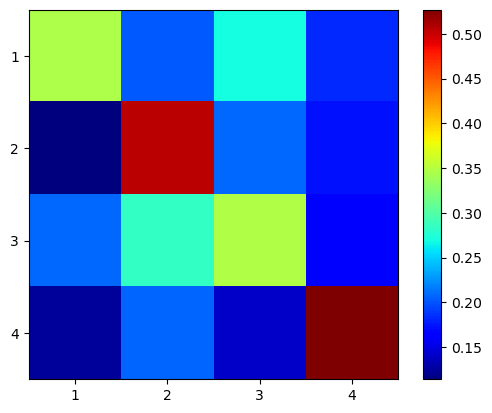

In [41]:
plt.imshow(msm.transition_matrix,cmap = "jet")
plt.colorbar()
plt.yticks(np.arange(4),np.arange(1,5))
plt.xticks(np.arange(4),np.arange(1,5))

In [42]:
print("mfpt 0-1 is", (msm.mfpt(0, 1)))
print("mfpt 0-2 is", (msm.mfpt(0, 2)))
print("mfpt 0-3 is", (msm.mfpt(0, 3)))
print("mfpt 1-0 is", (msm.mfpt(1, 0)))
print("mfpt 1-2 is", (msm.mfpt(1, 2)))
print("mfpt 1-3 is", (msm.mfpt(1, 3)))
print("mfpt 2-0 is", (msm.mfpt(2, 0)))
print("mfpt 2-1 is", (msm.mfpt(2, 1)))
print("mfpt 2-3 is", (msm.mfpt(2, 3)))
print("mfpt 3-0 is", (msm.mfpt(3, 0)))
print("mfpt 3-1 is", (msm.mfpt(3, 1)))
print("mfpt 3-2 is", (msm.mfpt(3, 2)))

mfpt 0-1 is 445.5180702148235
mfpt 0-2 is 461.82762791593143
mfpt 0-3 is 576.3869052236821
mfpt 1-0 is 726.0519454606208
mfpt 1-2 is 501.6404049462005
mfpt 1-3 is 583.5562473127691
mfpt 2-0 is 646.5614591284772
mfpt 2-1 is 405.84036091294894
mfpt 2-3 is 590.931107911192
mfpt 3-0 is 722.9355557262637
mfpt 3-1 is 449.5710225695534
mfpt 3-2 is 552.7459272012279


In [43]:
trj[frames_cl[0]].save_dcd("/home/apara/Documents/asn/tica/lig_47/dist/lig47_sig_cluster_1.dcd") #save frames
trj[frames_cl[1]].save_dcd("/home/apara/Documents/asn/tica/lig_47/dist/lig47_sig_cluster_2.dcd") #save frames
trj[frames_cl[2]].save_dcd("/home/apara/Documents/asn/tica/lig_47/dist/lig47_sig_cluster_3.dcd") #save frames
trj[frames_cl[3]].save_dcd("/home/apara/Documents/asn/tica/lig_47/dist/lig47_sig_cluster_4.dcd") #save frames